In [1]:
import numpy as np

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
from qiskit_textbook.tools import random_state, array_to_latex

In [2]:
# Create Quantum circuit
# Protocol uses 3 qubits and 2 classical bits in 2 different registers

qr = QuantumRegister(3, name="q")    # Protocol uses 3 qubits

# and 2 classical bits in 2 different registers

crz = ClassicalRegister(1, name="crz")
crx = ClassicalRegister(1, name="crx")

teleportation_circuit = QuantumCircuit(qr, crz, crx)

# Step 1

Telamon creates an entangled pair of qubits

In [3]:
def create_bell_pair(qc, a, b):
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target

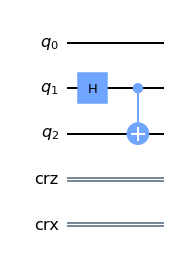

In [4]:
create_bell_pair(teleportation_circuit, 1, 2)
teleportation_circuit.draw()

# Step 2

Alice owns q<sub>1</sub> and Bob owns q<sub>2</sub>

Alice first applies CNOT aand then Hadamard to send the qubit q<sub>0</sub>

In [5]:
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

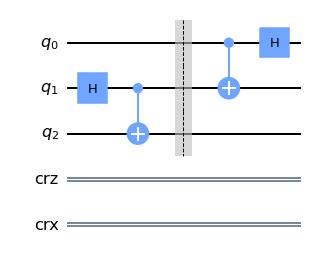

In [6]:
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)
teleportation_circuit.draw()

# Step 3

Alice applies a measurement to both qubits that she owns and stores this result in two classical bits before sending them to Bob

In [7]:
def measure_and_send(qc, a, b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)

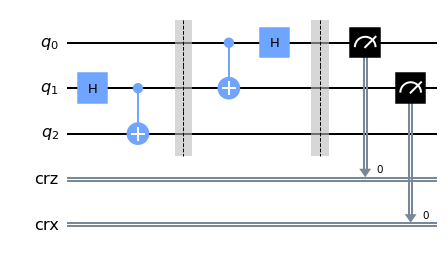

In [8]:
measure_and_send(teleportation_circuit, 0 ,1)
teleportation_circuit.draw()

# Step 4

Bob applies certain gates based upon the state of classical bits

In [9]:
# This function takes a QuantumCircuit (qc), integer (qubit) and ClassicalRegisters (crz & crx) to decide which gates to apply

def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical bit instead of a qubit
    
    # Apply gates if the registers are in the state '1'
    qc.x(qubit).c_if(crx, 1) 
    qc.z(qubit).c_if(crz, 1)

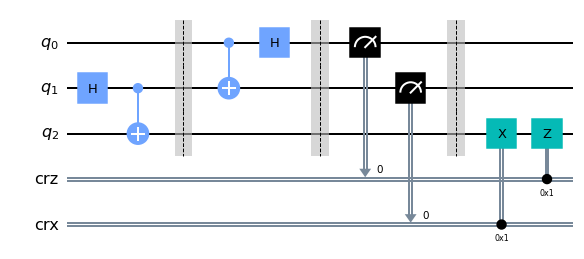

In [10]:
teleportation_circuit.barrier() # Use barrier to separate steps
bob_gates(teleportation_circuit, 2, crz, crx)
teleportation_circuit.draw()

**Alice's qubits have been teleported to Bob**

# Simulating the transportation protocol

Initialize Alice's qubit in a random state |ψ⟩. This state will be created using an initialize gate on |q<sub>0</sub>⟩
 

<IPython.core.display.Math object>

/opt/conda/lib/python3.8/site-packages/qiskit/visualization/bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


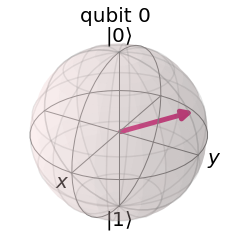

In [11]:
psi = random_state(1) # Create random 1-qubit state

array_to_latex(psi, pretext="|\\psi\\rangle =") # Display it nicely
plot_bloch_multivector(psi) # Show it on a Bloch sphere

In [12]:
# initialization instruction to create |ψ⟩ from the state |0⟩

init_gate = Initialize(psi)
init_gate.label = "init"

## Statevector simulator

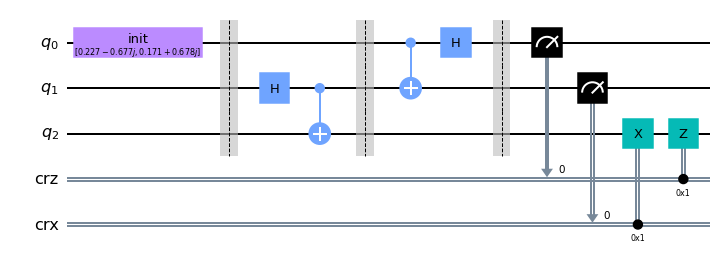

In [13]:
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

qc.append(init_gate, [0]) # Initialize Alice's q0
qc.barrier()

create_bell_pair(qc, 1, 2) # Now begin the teleportation protocol
qc.barrier()

alice_gates(qc, 0, 1) # Send q1 to Alice and q2 to Bob
measure_and_send(qc, 0, 1) # Alice sends her classical bits to Bob
bob_gates(qc, 2, crz, crx) # Bob decodes qubits

qc.draw()

State of |q<sub>2</sub>⟩ is the same as the state |ψ⟩, while the states of |q<sub>0</sub>⟩ and |q<sub>1</sub>⟩ have been collapsed to either |0⟩ or |1⟩. 

This means |ψ⟩ has been teleported from qubit 0 to qubit 2

/opt/conda/lib/python3.8/site-packages/qiskit/visualization/bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


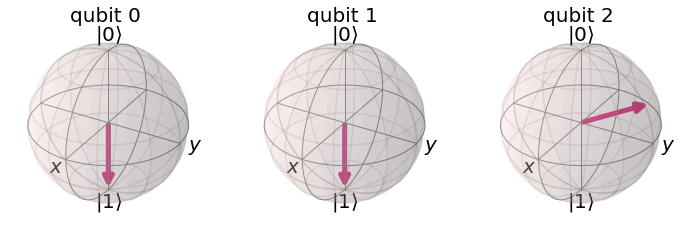

In [14]:
sv_sim = Aer.get_backend('statevector_simulator')
qobj = assemble(qc)
out_vector = sv_sim.run(qobj).result().get_statevector()
plot_bloch_multivector(out_vector)

## Qasm simulator

The Initialize instruction first performs a reset, setting our qubit to the state |0⟩. It then applies gates to turn our |0⟩ qubit into the state |ψ⟩ :

|0⟩ −−− Initialize gates −−→ |ψ⟩
 
Since all quantum gates are reversible, we can find the inverse of these gates.

This has the property |ψ⟩ −−−− Inverse Initialize gates −−−→ |0⟩

To prove the qubit |q<sub>0</sub>⟩ has been teleported to |q<sub>2</sub>⟩ we do this inverse initialization on |q<sub>2</sub>⟩ and expect to measure |0⟩ with some certainty

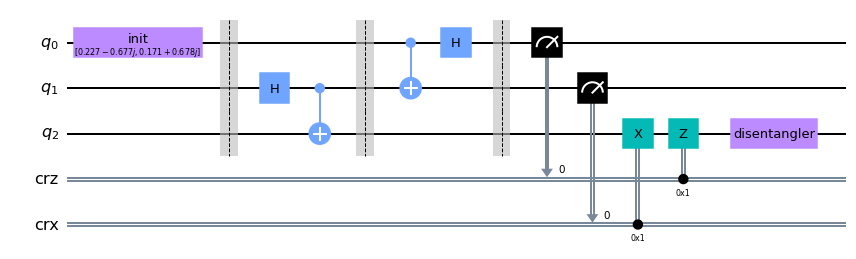

In [15]:
inverse_init_gate = init_gate.gates_to_uncompute()

# Protocol uses 3 qubits and 2 classical registers
qr = QuantumRegister(3, name="q")
crz = ClassicalRegister(1, name="crz")
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

qc.append(init_gate, [0]) # Initialize Alice's q0
qc.barrier()

create_bell_pair(qc, 1, 2) # Begin the teleportation protocol
qc.barrier()

alice_gates(qc, 0, 1) # Send q1 to Alice and q2 to Bob
measure_and_send(qc, 0, 1) # Alice then sends her classical bits to Bob
bob_gates(qc, 2, crz, crx) # Bob decodes qubits
qc.append(inverse_init_gate, [2]) # reverse the initialization process

qc.draw()

**inverse_init_gate appears labelled as 'disentangler'**. 

Finally, measure the third qubit and store the result in the third classical bit

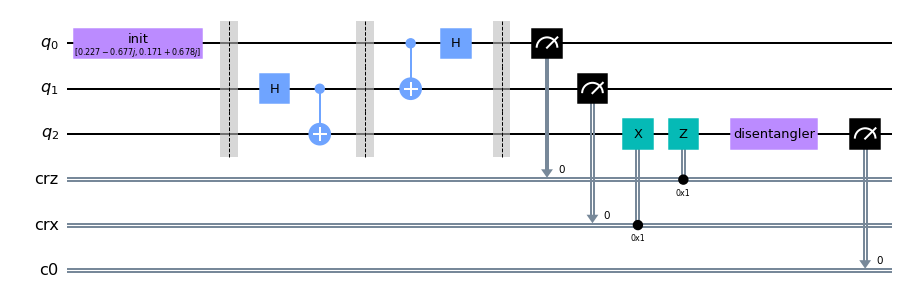

In [16]:
# Need to add a new ClassicalRegister to see the result

cr_result = ClassicalRegister(1)
qc.add_register(cr_result)
qc.measure(2,2)
qc.draw()

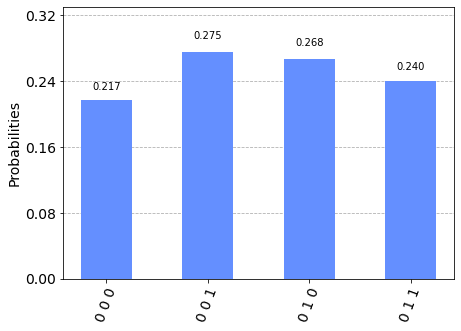

In [17]:
qasm_sim = Aer.get_backend('qasm_simulator')
t_qc = transpile(qc, qasm_sim)
qobj = assemble(t_qc)
counts = qasm_sim.run(qobj).result().get_counts()
plot_histogram(counts)

We can see we have a 100% chance of measuring q<sub>2</sub> in the state |0⟩. This is the expected result and indicates the teleportation protocol has worked properly